## Simulation of Consumption Growth

Prepared for OSM 2018

#### John Stachurski

In [1]:
import numpy as np
from numpy.random import randn
from numba import jit, njit, prange
import matplotlib.pyplot as plt

Our task is to simulate consumption growth in the model of Schorfheide, Song and Yaron (ECMA, 2018).

Parameter values are taken from that paper.


See the slides for details of the model.

In [2]:
@njit
def simulate_ssy(μ_c=0.0016,
                 ρ=0.987,
                 ϕ_z=0.215,
                 σ_bar=0.0032,
                 ϕ_c=1.0,
                 ρ_hz=0.992,
                 σ_hz=np.sqrt(0.0039),
                 ρ_hc=0.991,
                 σ_hc=np.sqrt(0.0096),
                 ts_length=1000):  

        # Initial conditions
        z, h_z, h_c = 0.0, 0.0, 0.0

        # Allocate memory  
        c_growth = np.zeros(ts_length)

        # Simulate all stochastic processes 
        for t in range(ts_length-1):
            σ_z = ϕ_z * σ_bar * np.exp(h_z)
            σ_c = ϕ_c * σ_bar * np.exp(h_c)
            
            # Evaluate consumption and dividends
            c_growth[t] = μ_c + z + σ_c * randn()

            # Update states
            z = ρ * z + np.sqrt(1 - ρ**2) * σ_z * randn()
            h_z = ρ_hz * h_z + σ_hz * randn()
            h_c = ρ_hc * h_c + σ_hc * randn()

        return c_growth[1:]

Let's simulate one consumption path of length 1000.

In [3]:
n = 10_000
c_growth = simulate_ssy(ts_length=n)
mean_c_growth = c_growth.mean()

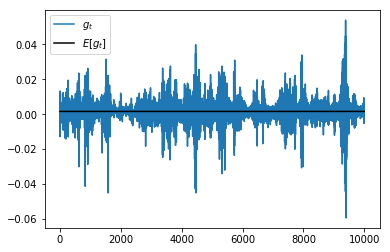

In [4]:
fig, ax = plt.subplots()
ax.plot(c_growth, label='$g_t$')
ax.plot(mean_c_growth * np.ones(n), 
        'k-', 
        label='$E[g_t]$')
ax.legend()
plt.show()

With a longer path, we can get a better estimate:

In [5]:
n = 1_000_000
c_growth = simulate_ssy(ts_length=n)
c_growth.mean()

0.001610655067811343

### Class Exercise

Since this model is asymptotically stationanry and ergodic, another way to compute the stationary mean is to simulate many independent paths to some suitably large $T$ and then take the average of the cross-section.

In other words, our estimate is

$$ \frac{1}{m} \sum_{i=1}^m g_T^i $$

where $g_T^i$ is consumption of the $i$-th household at time $T$.

Compute this estimate at the default parameter values using a large value of $m$, such as 1,000,000.

If possible, use parallelization to speed up your code.

In [6]:
for i in range(20):
    print("solution below!")

solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!


Here's a jitted function that returns one draw.

In [7]:
@njit
def compute_c_growth(μ_c=0.0016,
                 ρ=0.987,
                 ϕ_z=0.215,
                 σ_bar=0.0032,
                 ϕ_c=1.0,
                 ρ_hz=0.992,
                 σ_hz=np.sqrt(0.0039),
                 ρ_hc=0.991,
                 σ_hc=np.sqrt(0.0096),
                 T=1000):
    

    z, h_z, h_c = 0.0, 0.0, 0.0
    # Simulate all stochastic processes 
    for t in range(T):
        σ_z = ϕ_z * σ_bar * np.exp(h_z)
        # Update states
        z = ρ * z + np.sqrt(1 - ρ**2) * σ_z * randn()
        h_z = ρ_hz * h_z + σ_hz * randn()
        h_c = ρ_hc * h_c + σ_hc * randn()

    # Evaluate consumption 
    σ_c = ϕ_c * σ_bar * np.exp(h_c)
    c_growth = μ_c + z + σ_c * randn()
    return c_growth


In [8]:
compute_c_growth()

0.002671596387602368

Now let's compute a large number of draws in a parallelized loop.

In [9]:
@njit(parallel=True)
def compute_mean(m=1_000_000, T=1000):
    s = 0.0
    for i in prange(m):
        s += compute_c_growth(T=T)
    return s / m

In [10]:
compute_mean()

0.001592687024188061